1. Обучить AE собственной архитектуры на MNIST
1. Обучить VAE собственной архитектуры на MNIST
1. *Обучить VAE c переносом стиля на MNIST (на вход декодеру подавать hidden с таргетным значением, чтобы можно было нарисовать заданную цифру в заданном стиле)

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(
     root='.', train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root='.', train=False,
                           download=True, transform=ToTensor())

Обучить AE собственной архитектуры на MNIST

In [8]:
# hyperparameters
W = 28
H = 28
INP_DIM = W * H
HIDDEN = 400
OUT_DIM = 100
N_EPOCHS = 5
BATCH_SIZE = 64

In [9]:
class Encoder(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim, do_p=0.1):
        super().__init__()
        self.seq = nn.Sequential()
        self.seq.append(nn.Flatten())
        self.seq.append(nn.Linear(inp_dim, hid_dim))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(0.1))
        self.seq.append(nn.Linear(hid_dim, out_dim))

    def forward(self, x):
        return self.seq(x)

class Decoder(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim, do_p=0.1):
        super().__init__()
        self.seq = nn.Sequential()
        self.seq.append(nn.Linear(inp_dim, hid_dim))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(0.1))
        self.seq.append(nn.Linear(hid_dim, out_dim))

    def forward(self, x):
        return self.seq(x)

class LinearAutoencoder(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim, do_p=0.1):
        super().__init__()
        self.encoder = Encoder(inp_dim, hid_dim, out_dim, do_p)
        self.decoder = Decoder(out_dim, hid_dim, inp_dim, do_p)

    def forward(self, x):
        x_ = self.decoder(self.encoder(x))
        return x_

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, X.squeeze().flatten(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, _ in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X.squeeze().flatten(1)).item()
    test_loss /= num_batches
    print('Test Error:')
    print(f'Avg loss: {test_loss:>8f} \n')

In [11]:
test_dataloader = DataLoader(
    test_data, BATCH_SIZE, shuffle=True, drop_last=True)
model = LinearAutoencoder(INP_DIM, HIDDEN, OUT_DIM)
loss_fn = nn.MSELoss()
optim = Adam(model.parameters())

In [12]:
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}\n-------------------------------")
    train_dataloader = DataLoader(
        train_data, BATCH_SIZE, shuffle=True, drop_last=True)
    train(train_dataloader, model, loss_fn, optim)
    test(test_dataloader, model, loss_fn)
print('Done!')

Epoch 1
-------------------------------
loss: 0.112254  [    0/60000]
loss: 0.029888  [ 6400/60000]
loss: 0.021206  [12800/60000]
loss: 0.019887  [19200/60000]
loss: 0.018172  [25600/60000]
loss: 0.017194  [32000/60000]
loss: 0.015242  [38400/60000]
loss: 0.016574  [44800/60000]
loss: 0.015566  [51200/60000]
loss: 0.014350  [57600/60000]
Test Error:
Avg loss: 0.011122 

Epoch 2
-------------------------------
loss: 0.014885  [    0/60000]
loss: 0.013219  [ 6400/60000]
loss: 0.013688  [12800/60000]
loss: 0.013810  [19200/60000]
loss: 0.013136  [25600/60000]
loss: 0.013663  [32000/60000]
loss: 0.012827  [38400/60000]
loss: 0.013631  [44800/60000]
loss: 0.011534  [51200/60000]
loss: 0.012814  [57600/60000]
Test Error:
Avg loss: 0.009259 

Epoch 3
-------------------------------
loss: 0.011585  [    0/60000]
loss: 0.011657  [ 6400/60000]
loss: 0.012922  [12800/60000]
loss: 0.012847  [19200/60000]
loss: 0.012243  [25600/60000]
loss: 0.012168  [32000/60000]
loss: 0.011799  [38400/60000]
loss

In [19]:
def check():
    test_size = test_data.data.size()[0]
    n = np.random.randint(0, test_size - 1)
    print(test_data[n][1])
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(test_data.data[n].detach().numpy())
    axes[0].set_axis_off()
    axes[1].imshow(model(test_data[n][0]).view(28, 28).detach().numpy())
    axes[1].set_axis_off()
    plt.show()

7


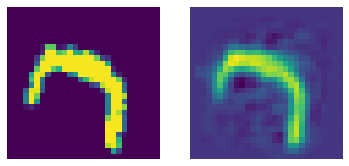

In [27]:
check()

Convolutional autoencoder

In [28]:
class ConvEncoder(nn.Module):
    def __init__(self, inp_ch, hid_ch, out_ch, do_p=0.1):
        super().__init__()
        self.seq = nn.Sequential()
        self.seq.append(nn.Conv2d(inp_ch, hid_ch, kernel_size=5, stride=2, padding=2))
        self.seq.append(nn.BatchNorm2d(hid_ch))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(do_p))
        self.seq.append(nn.Conv2d(hid_ch, hid_ch, kernel_size=3, stride=2, padding=1))
        self.seq.append(nn.BatchNorm2d(hid_ch))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(do_p))
        self.seq.append(nn.Conv2d(hid_ch, out_ch, kernel_size=3, stride=1, padding=1))
    
    def forward(self, x):
        return self.seq(x)

class ConvDecoder(nn.Module):
    def __init__(self, inp_ch, hid_ch, out_ch, do_p=0.1):
        super().__init__()
        self.seq = nn.Sequential()
        self.seq.append(nn.Conv2d(inp_ch, hid_ch, kernel_size=3, stride=1, padding=1))
        self.seq.append(nn.UpsamplingNearest2d(scale_factor=2))
        self.seq.append(nn.BatchNorm2d(hid_ch))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(do_p))
        self.seq.append(nn.Conv2d(hid_ch, hid_ch, kernel_size=3, stride=1, padding=1))
        self.seq.append(nn.UpsamplingNearest2d(scale_factor=2))
        self.seq.append(nn.BatchNorm2d(hid_ch))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(do_p))
        self.seq.append(nn.Conv2d(hid_ch, out_ch, kernel_size=5, stride=1, padding=2))
        
    def forward(self, x):
        return self.seq(x)

In [29]:
class ConvAE(nn.Module):
    def __init__(self, inp_ch, hid_ch, out_ch, do_p=0.1):
        super().__init__()
        self.encode = ConvEncoder(inp_ch, hid_ch, out_ch, do_p)
        self.decode = ConvDecoder(out_ch, hid_ch, inp_ch, do_p)
    
    def forward(self, x):
        encoded = self.encode(x)
        x_ = self.decode(encoded)
        return x_

In [34]:
# hyperparameters
INP_CH = 1
HID_CH = 200
OUT_CH = 1
N_EPOCHS = 5
BATCH_SIZE = 128

In [52]:
def conv_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def conv_test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, _ in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
    test_loss /= num_batches
    print('Test Error:')
    print(f'Avg loss: {test_loss:>8f} \n')

In [53]:
conv_model = ConvAE(INP_CH, HID_CH, OUT_CH)
loss_fn = nn.MSELoss()
conv_optim = Adam(conv_model.parameters())
test_dataloader = DataLoader(
    test_data, BATCH_SIZE, shuffle=True, drop_last=True)

In [55]:
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}\n-------------------------------")
    train_dataloader = DataLoader(
        train_data, BATCH_SIZE, shuffle=True, drop_last=True)
    conv_train(train_dataloader, conv_model, loss_fn, conv_optim)
    conv_test(test_dataloader, conv_model, loss_fn)
print('Done!')

Epoch 1
-------------------------------
loss: 0.030972  [    0/60000]
loss: 0.026053  [12800/60000]
loss: 0.024482  [25600/60000]
loss: 0.019784  [38400/60000]
loss: 0.018828  [51200/60000]
Test Error:
Avg loss: 0.013276 

Epoch 2
-------------------------------
loss: 0.018089  [    0/60000]
loss: 0.017257  [12800/60000]
loss: 0.015216  [25600/60000]
loss: 0.015994  [38400/60000]
loss: 0.013760  [51200/60000]
Test Error:
Avg loss: 0.010395 

Epoch 3
-------------------------------
loss: 0.013575  [    0/60000]
loss: 0.014150  [12800/60000]
loss: 0.013635  [25600/60000]
loss: 0.013892  [38400/60000]
loss: 0.012244  [51200/60000]
Test Error:
Avg loss: 0.009237 

Epoch 4
-------------------------------
loss: 0.011712  [    0/60000]
loss: 0.010824  [12800/60000]
loss: 0.010260  [25600/60000]
loss: 0.011526  [38400/60000]
loss: 0.013012  [51200/60000]
Test Error:
Avg loss: 0.008575 

Epoch 5
-------------------------------
loss: 0.010641  [    0/60000]
loss: 0.011222  [12800/60000]
loss: 0.

In [58]:
def conv_check():
    test_size = test_data.data.size()[0]
    n = np.random.randint(0, test_size - 1)
    print(test_data[n][1])
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(test_data.data[n].detach().numpy())
    axes[0].set_axis_off()
    axes[1].imshow(conv_model(test_data[n][0].unsqueeze(0)).view(28, 28).detach().numpy())
    axes[1].set_axis_off()
    plt.show()

9


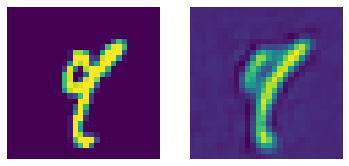

In [60]:
conv_check()

Обучить VAE собственной архитектуры на MNIST

In [61]:
class VarEncoder(nn.Module):
    def __init__(self, inp_ch, hid_ch, do_p=0.1):
        super().__init__()
        self.seq = nn.Sequential()
        self.seq.append(
            nn.Conv2d(inp_ch, hid_ch, kernel_size=5, stride=2, padding=2))
        self.seq.append(nn.BatchNorm2d(hid_ch))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(do_p))
        self.seq.append(
            nn.Conv2d(hid_ch, hid_ch, kernel_size=3, stride=2, padding=1))
        self.seq.append(nn.BatchNorm2d(hid_ch))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(do_p))
        self.seq.append(
            nn.Conv2d(hid_ch, 2, kernel_size=3, stride=1, padding=1))

    def forward(self, x):
        mu, sigma = self.seq(x).split(1, dim=1)
        sigma = torch.exp(sigma)
        return mu, sigma


class VarDecoder(nn.Module):
    def __init__(self, hid_ch, out_ch, do_p=0.1):
        super().__init__()
        self.seq = nn.Sequential()
        self.seq.append(
            nn.Conv2d(1, hid_ch, kernel_size=3, stride=1, padding=1))
        self.seq.append(nn.UpsamplingNearest2d(scale_factor=2))
        self.seq.append(nn.BatchNorm2d(hid_ch))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(do_p))
        self.seq.append(
            nn.Conv2d(hid_ch, hid_ch, kernel_size=3, stride=1, padding=1))
        self.seq.append(nn.UpsamplingNearest2d(scale_factor=2))
        self.seq.append(nn.BatchNorm2d(hid_ch))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(do_p))
        self.seq.append(
            nn.Conv2d(hid_ch, out_ch, kernel_size=5, stride=1, padding=2))

    def forward(self, x):
        return self.seq(x)

In [62]:
class ConvVarAutoEncoder(nn.Module):
    def __init__(self, inp_ch, hid_ch, do_p=0.1):
        super().__init__()
        self.encoder = VarEncoder(inp_ch, hid_ch, do_p)
        self.decoder = VarDecoder(hid_ch, inp_ch, do_p)

    def forward(self, x):
        mu, sigma = self.encoder(x)
        norm = torch.normal(torch.zeros_like(mu), torch.ones_like(sigma))
        hidden = mu + sigma * norm
        x_ = self.decoder(hidden)
        return x_, mu, sigma

In [63]:
# hyperparameters
INP_CH = 1
HID_CH = 100
BATCH_SIZE = 64
N_EPOCHS = 5
KL_COEF = 0.01

In [64]:
def vae_loss_fn(pred, y, mu, sigma, coef=0.01):
    mse_loss = nn.MSELoss()(pred, y)
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(
        torch.zeros_like(mu), torch.ones_like(sigma))
    kl_loss = torch.distributions.kl_divergence(p, q).mean()

    return mse_loss + coef * kl_loss

In [73]:
vae_model = ConvVarAutoEncoder(INP_CH, HID_CH)
vae_optim = Adam(vae_model.parameters())

In [74]:
def vae_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        pred, mu, sigma = model(X)
        loss = loss_fn(pred, X, mu, sigma, KL_COEF)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

In [75]:
def vae_test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            pred, mu, sigma = model(X)
            test_loss += loss_fn(pred, X, mu, sigma, KL_COEF).item()
    test_loss /= num_batches
    print('Test Error:')
    print(f'Avg loss: {test_loss:>8f} \n')

In [76]:
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}\n-------------------------------")
    train_dataloader = DataLoader(
    	train_data, BATCH_SIZE, shuffle=True, drop_last=True)
    vae_train(train_dataloader, vae_model, vae_loss_fn, vae_optim)
    vae_test(test_dataloader, vae_model, vae_loss_fn)
print('Done!')

Epoch 1
-------------------------------
loss: 0.335612 [    0/60000]
loss: 0.050121 [ 6400/60000]
loss: 0.042349 [12800/60000]
loss: 0.039049 [19200/60000]
loss: 0.035844 [25600/60000]
loss: 0.032455 [32000/60000]
loss: 0.032267 [38400/60000]
loss: 0.030517 [44800/60000]
loss: 0.029675 [51200/60000]
loss: 0.028101 [57600/60000]
Test Error:
Avg loss: 0.025938 

Epoch 2
-------------------------------
loss: 0.028495 [    0/60000]
loss: 0.028771 [ 6400/60000]
loss: 0.027510 [12800/60000]
loss: 0.028546 [19200/60000]
loss: 0.025190 [25600/60000]
loss: 0.026602 [32000/60000]
loss: 0.027450 [38400/60000]
loss: 0.026726 [44800/60000]
loss: 0.025213 [51200/60000]
loss: 0.025692 [57600/60000]
Test Error:
Avg loss: 0.023953 

Epoch 3
-------------------------------
loss: 0.026107 [    0/60000]
loss: 0.024798 [ 6400/60000]
loss: 0.026601 [12800/60000]
loss: 0.024963 [19200/60000]
loss: 0.025805 [25600/60000]
loss: 0.025384 [32000/60000]
loss: 0.024398 [38400/60000]
loss: 0.026576 [44800/60000]
lo

In [77]:
def check():
    test_size = test_data.data.size()[0]
    n = np.random.randint(0, test_size - 1)
    print(test_data[n][1])
    plt.imshow(vae_model(test_data[n][0].unsqueeze(0))
               [0].detach().squeeze().numpy())
    plt.show()

6


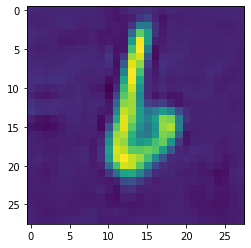

In [87]:
check()

In [93]:
def generate(shift=0, deviation=0):
    hidden = torch.normal(torch.zeros(1, 1, 7, 7) + shift,
                          torch.ones(1, 1, 7, 7) * deviation)
    x_ = vae_model.decoder(hidden)
    plt.imshow(x_[0].detach().squeeze().numpy())
    plt.show()

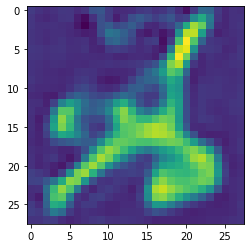

In [102]:
generate(0.3, 1.2)